In [1]:
import parmed as pmd
# import emcee
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from KDEpy import FFTKDE
from scipy import constants
from scipy.optimize import minimize


In [24]:
gmx = pmd.gromacs.GromacsTopologyFile("charmm/charmm36-jul2022.ff/forcefield.itp")
param_set = pmd.charmm.parameters.CharmmParameterSet.from_parameterset(gmx.parameterset)

In [25]:
for cmap_type in param_set.cmap_types.values():
    print(np.exp(np.array(cmap_type.grid._data)).max())

845.5607358510359
845.5607358510359
845.5607358510359
845.5607358510359
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224
845.5607358510359
845.5607358510359
845.5607358510359
845.5607358510359
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
128.95970613166207
128.95970613166207
931.9694172148131
931.9694172148131
846.923185113112
846.923185113112
846.923185113112
846.923185113112
846.923185113112
846.923185113112
846.923185113112
846.923185113112
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
194755.46013954005
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224
40.609417587812224


In [26]:
mins = np.array([min(cmap_type.grid._data) for cmap_type in param_set.cmap_types.values()])
maxs = np.array([max(cmap_type.grid._data) for cmap_type in param_set.cmap_types.values()])

In [27]:
mins

array([-7.05   , -7.05   , -7.05   , -7.05   , -1.2566 , -1.2566 ,
       -1.2566 , -1.2566 , -6.2059 , -6.2059 , -6.2059 , -6.2059 ,
       -7.05   , -7.05   , -7.05   , -7.05   , -1.2566 , -1.2566 ,
       -1.2566 , -1.2566 , -3.96148, -3.96148, -4.3794 , -4.3794 ,
       -7.03483, -7.03483, -7.03483, -7.03483, -7.03483, -7.03483,
       -7.03483, -7.03483, -1.2566 , -1.2566 , -1.2566 , -1.2566 ,
       -1.2566 , -1.2566 , -1.2566 , -1.2566 , -6.2059 , -6.2059 ,
       -6.2059 , -6.2059 , -6.2059 , -6.2059 , -6.2059 , -6.2059 ])

In [28]:
np.min(mins), np.max(maxs)

(-7.05, 12.1795)

In [29]:
maxs[mins == np.min(mins)]

array([6.74, 6.74, 6.74, 6.74, 6.74, 6.74, 6.74, 6.74])

(array([16., 12.,  0.,  0.,  2.,  2.,  0.,  0.,  0., 16.]),
 array([-7.05   , -6.47066, -5.89132, -5.31198, -4.73264, -4.1533 ,
        -3.57396, -2.99462, -2.41528, -1.83594, -1.2566 ]),
 <BarContainer object of 10 artists>)

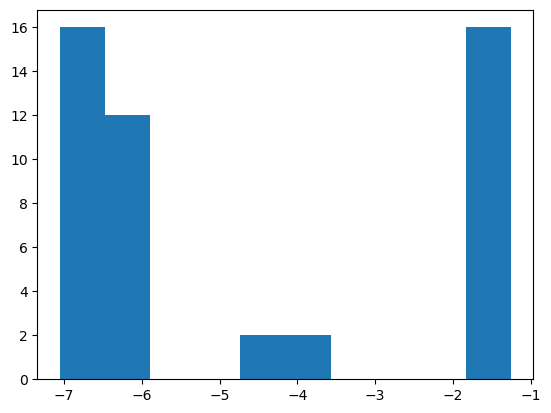

In [31]:
plt.hist(mins)

In [32]:
maxs = np.array([max(cmap_type.grid._data) for cmap_type in param_set.cmap_types.values()])

In [34]:
maxs[mins == -7.05]

array([6.74, 6.74, 6.74, 6.74, 6.74, 6.74, 6.74, 6.74])

(array([12.,  2.,  0., 18.,  0.,  0.,  0.,  0.,  0., 16.]),
 array([ 3.704  ,  4.55155,  5.3991 ,  6.24665,  7.0942 ,  7.94175,
         8.7893 ,  9.63685, 10.4844 , 11.33195, 12.1795 ]),
 <BarContainer object of 10 artists>)

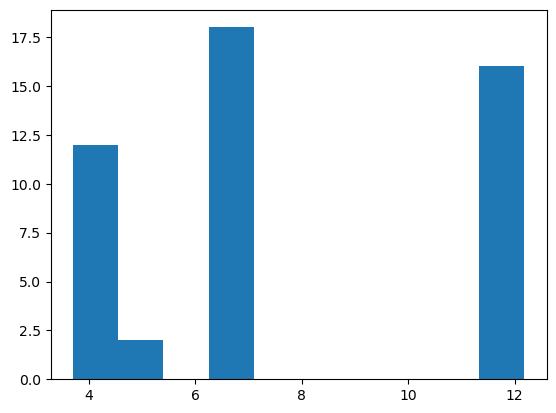

In [8]:
plt.hist(maxs)

In [20]:

from scipy import constants
R = constants.R / (constants.calorie * 1e3)

RT = R * 300

-RT

-0.5961612775812619

In [21]:
np.exp(mins/RT)

array([7.50296034e-06, 7.50296034e-06, 7.50296034e-06, 7.50296034e-06,
       6.52732141e-08, 6.52732141e-08, 6.52732141e-08, 6.52732141e-08,
       1.19820445e-05, 1.19820445e-05, 1.19820445e-05, 1.19820445e-05])

1.1920929e-07

In [32]:
np.format_float_scientific(np.exp(-7.05))

'8.674089573070025e-04'

In [9]:
max(max(cmap_type.grid._data) for cmap_type in param_set.cmap_types.values())

12.1795

In [26]:
np.log(np.finfo("float32").eps)

-15.942385

In [23]:
np.finfo("float32").eps

1.1920929e-07

In [ ]:
param_set.cmap_types

In [ ]:

def build_logp(cmap_type):
    RT = 0.592 # kcal / mol
    # R = constants.R / (constants.calorie * 1e3)
    # RT = R * 298

    res = cmap_type.resolution
    V = np.array(cmap_type.grid).reshape(res, res)
    logp = -V / RT
    # logp = -V

    ext_logp = np.empty([dim + 1 for dim in logp.shape])

    ext_logp[:-1, :-1] = logp
    ext_logp[:-1, -1] = logp[:, 0]
    ext_logp[-1, :-1] = logp[0, :]
    ext_logp[-1, -1] = logp[0, 0]

    return ext_logp

logps = [build_logp(cmap_type) for cmap_type in param_set.cmap_types.values()]
# logps = [logp for logp in logps if np.exp(logp.min()) == 1.1615857613434818e-09]


In [ ]:
for logp in logps:
    print(logp.min())

In [ ]:
res = next(iter(logps)).shape[0]

angs = np.linspace(-np.pi, np.pi, res)
method = "slinear"

interps = [RegularGridInterpolator((angs, angs), logp, method=method) for logp in logps]


In [ ]:
def log_prob(x, interp):
    mask = np.any((x < -np.pi) | (x > np.pi), axis=1)
    x[mask, :] = np.array([0.0, 0.0])
    logp = interp(x)
    logp[mask] = -np.inf
    return logp

In [ ]:
from math import ceil

def sample(interp, nsamples):
    ndim = 2
    nwalkers = 32
    # nwalkers = 4
    samples_per_chain = ceil(nsamples / nwalkers)
    p0 = np.pi * (2 * np.random.rand(nwalkers, ndim) - 1)

    # sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[interp], vectorize=True)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[interp], vectorize=False)
    sampler.run_mcmc(p0, 1_000 + samples_per_chain)

    samples = sampler.get_chain()
    return samples[-samples_per_chain:].reshape(-1, 2)


samples_arr = []

for interp in interps:
    samples_arr.append(sample(interp, 600_000))
    # samples_arr.append(sample(interp, 1_000))

In [ ]:
sample(interp, 60_000)

In [ ]:
kernel = "gaussian"
factor = 10
l = (res - 1) * factor
angs = np.linspace(-np.pi, np.pi, l + 1)
kde_grid = np.stack(np.meshgrid(angs, angs, indexing="ij"), axis=-1).reshape(-1, 2)
assert np.allclose(angs[::factor], np.linspace(-np.pi, np.pi, res))

In [ ]:
def loss(x, samples, true_logp):
    # bw, eps = x
    (bw, k) = x
    # eps = 5.134644231712484e-06
    eps = 1.1615857613434818e-09
    kde = FFTKDE(bw=bw, kernel=kernel)
    kde.fit(samples)

    pdf = kde.evaluate(kde_grid).reshape(l + 1, l + 1)
    pdf = pdf[::factor, ::factor]

    # est_logp = np.log(pdf + np.exp(eps))
    est_logp = np.log(k * pdf + eps)

    return np.sum((est_logp[:-1, :-1] - true_logp[:-1, :-1]) ** 2)

# def cum_loss(x, samples_arr, logps):
#     tot = 0.0

#     for samples, true_logp in zip(samples_arr, logps):
#         tot += loss(x, samples, true_logp)

#     return tot

In [ ]:
# out = minimize(cum_loss, x0=[2e-1], bounds=[(1e-5, 10)], args=(samples_arr, logps))

In [ ]:
#   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
#   success: True
#    status: 0
#       fun: 74556.91129774158
#         x: [ 3.002e-01]
#       nit: 14
#       jac: [ 8.310e+03]
#      nfev: 298
#      njev: 149
#  hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


#   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
#   success: True
#    status: 0
#       fun: 137949.50214250557
#         x: [ 4.544e-01]
#       nit: 6
#       jac: [ 1.224e+05]
#      nfev: 86
#      njev: 43
#  hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [ ]:
bws = []
# epses = []
for samples, true_logp in zip(samples_arr, logps):
    # out = minimize(loss, x0=[2e-1, 2.6e-6], bounds=[(1e-10, 10), (0, None)], args=(samples, true_logp))
    # out = minimize(loss, x0=[2e-1, -12], bounds=[(1e-5, 10), (None, 10)], args=(samples, true_logp))
    out = minimize(loss, x0=[2e-1, 1], bounds=[(1e-5, 10), (0, None)], args=(samples, true_logp))
    print(out.success, out.fun, out.x)
    if not out.success:
        print(out.message)
    # bw, eps = out.x
    (bw, k) = out.x
    # break
    bws.append(bw)
    # epses.append(eps)


bws = np.array(bws)
# epses = np.array(epses)

In [ ]:
plt.hist(bws)

In [ ]:
bws.mean(), bws.std()

In [ ]:
plt.plot(bws, epses, "o")
plt.yscale("log")
plt.xscale("log")

In [ ]:
plt.imshow(resampled_cmap.reshape(l, l).T, origin="lower", cmap="seismic", norm=CenteredNorm())
plt.colorbar()

In [ ]:
plt.imshow(grid.T, origin="lower", cmap="seismic", norm=CenteredNorm())
plt.colorbar()